In [1]:
from modules.data import data_reader, data_loader, time_series_analysis
import pandas as pd
import numpy as np
import os

In [2]:
#evaluation = data_reader.read_data(match=["stock"], location="evaluation")
#prediction = data_reader.read_data(match=["stock"], location="prediction")

In [3]:
def save_dataframe_to_csv(dataframe: pd.DataFrame, file_path: str):
    """
    Saves a pandas DataFrame to a CSV file at the specified location.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame to save.
    file_path (str): The location where the CSV file will be saved.

    Returns:
    None
    """
    try:
        dataframe.to_csv(file_path, index=True)
        print(f"DataFrame saved successfully to {file_path}")
    except Exception as e:
        print(f"An error occurred while saving the DataFrame: {e}")

# Data aggregation

In [4]:
# path to evaluation directory
project_folder = os.getcwd()
directory = os.path.abspath(os.path.join(project_folder, "results", "evaluation"))
aggregated_results_directory = os.path.abspath(os.path.join(project_folder, "results", "aggregated_results"))

In [5]:
# Initialize an empty DataFrame to store the aggregated results
aggregated_evaluation = pd.DataFrame()
aggregated_ranking = pd.DataFrame()

In [6]:
# List all files in the directory
files = [f for f in os.listdir(directory) if f.endswith('.csv')]

In [7]:
# Process each file and add to aggregated evaluation

higher_better = ['r2', 'mda']
lower_better = ['mse', 'mae', 'rmse', 'mape']

for file in files:
    # Extract parameters from the file name
    base_name = os.path.splitext(file)[0]
    parameters = base_name.split('_')
    param_dict = {}
    for param in parameters:
        key, value = param.split('=')
        param_dict[key] = value

    # Read the CSV file into a DataFrame
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path)
    df.rename(columns={"Unnamed: 0" : "model"}, inplace=True)

    
    

    # Add parameter columns to the DataFrame
    for key, value in param_dict.items():
        df[key] = value

    # creating the ranking df
    ranked_df = df.copy()
    ranked_df['model'] = df['model']

    # Rank the models for each metric and add to the new DataFrame
    for metric in higher_better:
        ranked_df[metric] = df[metric].rank(ascending=False, method='min').astype(int)

    for metric in lower_better:
        ranked_df[metric] = df[metric].rank(ascending=True, method='min').astype(int)

    # Append the DataFrame to the aggregated DataFrame
    aggregated_evaluation = pd.concat([aggregated_evaluation, df], ignore_index=True)
    aggregated_ranking = pd.concat([aggregated_ranking, ranked_df], ignore_index=True)


In [8]:
def determine_trend(row):
    if row['quadratic_trend']:
        return 'quadratic'
    elif row['linear_trend']:
        return 'linear'
    else:
        return 'no_trend'

def add_data_features(df):
    old_names = list(df.columns)
    data_features = ["stationary", "adf_statistic", "linear_trend",
                                                     "linear_tau", "quadratic_trend", "quadratic_tau",
                                                       "cyclical_patterns", "n_partial_autocorrelations", 'residual_volatility', "residual_mean"]

    data_params = ['SD', 'ED', 'FR', 'T', 'TOD']
    new_df = pd.DataFrame(columns = data_params + data_features)

    

    unique_data_combinations = df.drop_duplicates(subset=data_params)[data_params]


    for i, data_combination in unique_data_combinations.iterrows():



        type = data_combination["TOD"]
        ticker = data_combination["T"]
        frequency = data_combination["FR"]
        start = data_combination["SD"]
        end = data_combination["ED"]

        if ticker == "USDGBP":
            ticker = "USD/GBP"

        
        data =  data_loader.get_data(type = type, ticker = ticker,
                                      frequency = frequency, start = start,
                                        end = end, rtrn = True)
        

        data_features = time_series_analysis.analyze_time_series(data)
        row = {}
        for k in data_params:
            row[k] = data_combination[k]
        for k in data_features.keys():
            row[k] = data_features[k]

        #return new_df
        new_df = pd.concat([new_df, pd.DataFrame([row])], ignore_index=True)
        #return new_df

    output = df.merge(new_df, on = data_params, how = "left")
            
    output['trend'] = output.apply(determine_trend, axis=1)
    output = output.drop(columns=['quadratic_trend', 'linear_trend'])
    
    return output




In [ ]:
aggregated_ranking_with_data_features = add_data_features(aggregated_ranking)

In [10]:
pd.set_option('display.max_columns', 500)
aggregated_ranking_with_data_features

,model,r2,mse,mae,rmse,mda,mape,T,FR,TOD,FO,CLTS,SD,ED,FTL,FTF,FTG,TSCVR,BS,ME,stationary,adf_statistic,linear_tau,quadratic_tau,cyclical_patterns,n_partial_autocorrelations,residual_volatility,residual_mean,trend
0,arima,2,2,1,2,2,2,Aggregate,daily,cc,5,128,2020-01-01,2022-01-01,200,5,0,6,5,4,True,-3.406147,0.343862,0.343862,True,13,0.0,0.0,quadratic
1,autoregressor,1,1,2,1,2,1,Aggregate,daily,cc,5,128,2020-01-01,2022-01-01,200,5,0,6,5,4,True,-3.406147,0.343862,0.343862,True,13,0.0,0.0,quadratic
2,ft_lag_llama,5,5,5,5,6,5,Aggregate,daily,cc,5,128,2020-01-01,2022-01-01,200,5,0,6,5,4,True,-3.406147,0.343862,0.343862,True,13,0.0,0.0,quadratic
3,ft_timeGPT,4,4,4,4,4,4,Aggregate,daily,cc,5,128,2020-01-01,2022-01-01,200,5,0,6,5,4,True,-3.406147,0.343862,0.343862,True,13,0.0,0.0,quadratic
4,lag_llama,6,6,7,6,5,6,Aggregate,daily,cc,5,128,2020-01-01,2022-01-01,200,5,0,6,5,4,True,-3.406147,0.343862,0.343862,True,13,0.0,0.0,quadratic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,ft_lag_llama,1,1,1,1,2,1,WTI,weekly,commodity,5,64,2019-01-01,2024-01-01,200,5,0,6,5,4,True,-17.053779,-0.040154,0.029938,False,1,0.0,0.0,no_trend
1354,ft_timeGPT,4,4,4,4,7,4,WTI,weekly,commodity,5,64,2019-01-01,2024-01-01,200,5,0,6,5,4,True,-17.053779,-0.040154,0.029938,False,1,0.0,0.0,no_trend
1355,lag_llama,7,7,7,7,3,6,WTI,weekly,commodity,5,64,2019-01-01,2024-01-01,200,5,0,6,5,4,True,-17.053779,-0.040154,0.029938,False,1,0.0,0.0,no_trend
1356,prophet,3,3,2,3,1,2,WTI,weekly,commodity,5,64,2019-01-01,2024-01-01,200,5,0,6,5,4,True,-17.053779,-0.040154,0.029938,False,1,0.0,0.0,no_trend


In [11]:
sum(aggregated_ranking_with_data_features["cyclical_patterns"])

546

In [87]:
import numpy as np
aggregated_ranking[np.logical_and(np.logical_and(aggregated_ranking["FR"] == "monthly", 
                                                 aggregated_ranking["model"] == "arima"), 
                                                 aggregated_ranking["TOD"] == "commodity")]["D"].unique()

array(['2024-01-01'], dtype=object)

# Quantifying the difference between best model and others

In [35]:
temp = aggregated_ranking[aggregated_ranking["TOD"] == "commodity"]
metrics = ["r2", "mse", "mae", "rmse", "mda", "mape", "model"]
group = ["model"]
a = temp[metrics].groupby(group).mean()

In [44]:
np.mean(a["r2"])

4.0

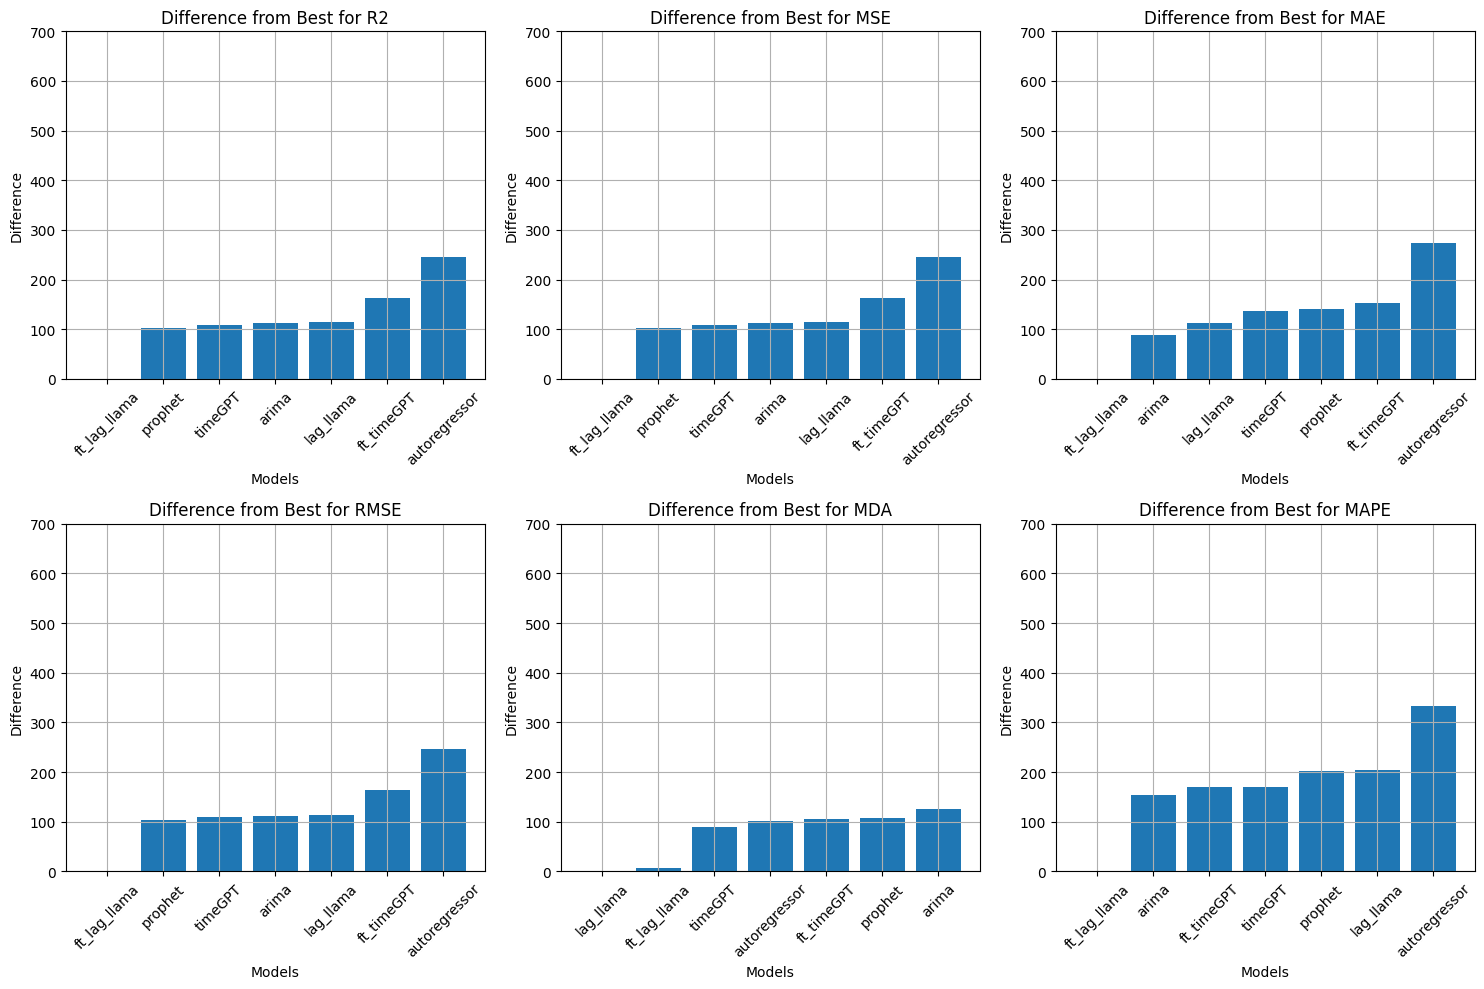

In [54]:
df = a
import pandas as pd
import matplotlib.pyplot as plt

# Set the model as the index
df.reset_index(inplace=True)  # This will convert the index into a column
df.set_index('model', inplace=True)

# Initialize a subplot for each column
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# List of metrics/columns to iterate through
metrics = ['r2', 'mse', 'mae', 'rmse', 'mda', 'mape']
axes = axes.flatten()

# Plotting the difference for each metric
for i, metric in enumerate(metrics):
    # Get the minimum value (best model) for the current metric
    min_value = df[metric].min()
    
    # Calculate the difference between the best model and all others
    diff = (df[metric] - min_value)/min_value * 100
    
    # Sort by the difference to ensure models are ordered from smallest to largest difference
    diff_sorted = diff.sort_values()
    
    # Plotting the difference as a vertical bar chart
    axes[i].bar(diff_sorted.index, diff_sorted)
    axes[i].set_title(f'Difference from Best for {metric.upper()}')
    axes[i].set_xlabel('Models')
    axes[i].set_ylabel('Difference')
    axes[i].grid(True)  # Adding gridlines
    
    # Set the y-axis range from 0 to 7 for all subplots
    axes[i].set_ylim(0, 700)
    
    # Rotate x-axis labels for readability
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


# Just for weekly commodities

In [13]:
temp = aggregated_ranking[np.logical_and(aggregated_ranking["FR"] == "weekly", aggregated_ranking["TOD"] == "commodity")]
metrics = ["r2", "mse", "mae", "rmse", "mda", "mape", "model", "CLTS"]
group = ["CLTS", "model"]
temp[metrics].groupby(group).mean()


r2       mse       mae      rmse       mda      mape
CLTS model                                                                    
128  arima          5.000000  5.000000  4.333333  5.000000  5.333333  2.000000
     autoregressor  5.000000  5.000000  5.666667  5.000000  4.000000  6.000000
     ft_lag_llama   2.000000  2.000000  1.666667  2.000000  3.666667  1.000000
     ft_timeGPT     4.000000  4.000000  4.666667  4.000000  5.000000  5.000000
     lag_llama      4.333333  4.333333  4.333333  4.333333  1.666667  4.666667
     prophet        5.000000  5.000000  5.000000  5.000000  3.000000  5.666667
     timeGPT        2.666667  2.666667  2.333333  2.666667  3.333333  3.666667
32   arima          4.275862  4.275862  3.310345  4.275862  4.413793  4.034483
     autoregressor  6.310345  6.310345  6.655172  6.310345  4.448276  6.620690
     ft_lag_llama   1.379310  1.379310  1.344828  1.379310  1.655172  1.000000
     ft_timeGPT     5.241379  5.241379  4.689655  5.241379  4.413793  3.724138
     lag_llama      3.862069  3.862069  3.896552  3.862069  1.655172  4.689655
     prophet        2.931034  2.931034  3.827586  2.931034  5.517241  3.965517
     timeGPT        4.000000  4.000000  4.275862  4.000000  4.103448  3.965517
64   arima          3.666667  3.666667  3.333333  3.666667  5.000000  3.333333
     autoregressor  5.333333  5.333333  6.000000  5.333333  4.000000  6.000000
     ft_lag_llama   2.333333  2.333333  2.000000  2.333333  4.333333  1.000000
     ft_timeGPT     4.666667  4.666667  5.000000  4.666667  4.333333  5.333333
     lag_llama      4.666667  4.666667  4.666667  4.666667  2.666667  5.333333
     prophet        4.666667  4.666667  4.333333  4.666667  3.000000  2.666667
     timeGPT        2.666667  2.666667  2.666667  2.666667  2.666667  4.333333

In [14]:
aggregated_evaluation

,model,r2,mse,mae,rmse,mda,mape,T,FR,TOD,FO,CLTS,SD,ED,FTL,FTF,FTG,TSCVR,BS,ME
0,arima,0.986685,1.975011,0.944358,1.405351,0.724138,0.012358,Aggregate,daily,cc,5,128,2020-01-01,2022-01-01,200,5,0,6,5,4
1,autoregressor,0.988447,1.713623,0.975667,1.309054,0.724138,0.012344,Aggregate,daily,cc,5,128,2020-01-01,2022-01-01,200,5,0,6,5,4
2,ft_lag_llama,0.712041,42.711830,5.181047,6.535429,0.586207,0.068402,Aggregate,daily,cc,5,128,2020-01-01,2022-01-01,200,5,0,6,5,4
3,ft_timeGPT,0.968585,4.659727,1.425116,2.158640,0.655172,0.018760,Aggregate,daily,cc,5,128,2020-01-01,2022-01-01,200,5,0,6,5,4
4,lag_llama,0.419023,86.174151,6.983386,9.283003,0.620690,0.092600,Aggregate,daily,cc,5,128,2020-01-01,2022-01-01,200,5,0,6,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,ft_lag_llama,-0.006867,0.001537,0.032072,0.039211,0.551724,1.000000,WTI,weekly,commodity,5,64,2019-01-01,2024-01-01,200,5,0,6,5,4
1354,ft_timeGPT,-0.240189,0.001894,0.036149,0.043517,0.344828,6.302725,WTI,weekly,commodity,5,64,2019-01-01,2024-01-01,200,5,0,6,5,4
1355,lag_llama,-0.479615,0.002259,0.038999,0.047533,0.517241,8.613169,WTI,weekly,commodity,5,64,2019-01-01,2024-01-01,200,5,0,6,5,4
1356,prophet,-0.114293,0.001702,0.034048,0.041249,0.586207,3.648994,WTI,weekly,commodity,5,64,2019-01-01,2024-01-01,200,5,0,6,5,4


# Temp for confluence

In [69]:
temp = aggregated_evaluation[np.logical_and(aggregated_evaluation["TOD"] == "fx", aggregated_evaluation["FR"] == "weekly")]
metrics = ["r2", "mse", "mae", "rmse", "mda", "mape", "model"]
group = ["model"]
temp[metrics].groupby(group).mean()

,r2,mse,mae,rmse,mda,mape
model,,,,,,
arima,-0.143880,0.000129,0.008906,0.011239,0.245211,1.098492
autoregressor,-1.244841,0.000261,0.012411,0.015858,0.344828,3.903648
ft_lag_llama,-0.139080,0.000130,0.008759,0.011213,0.459770,1.063407
ft_timeGPT,-0.080239,0.000123,0.008906,0.010965,0.532567,1.624863
lag_llama,-4.303930,0.000592,0.020325,0.022726,0.498084,6.811605
prophet,-0.184719,0.000137,0.008925,0.011500,0.367816,1.529056
timeGPT,-0.380859,0.000158,0.009806,0.012383,0.318008,2.411165


In [15]:
# runs linear regression on the aggregated results and prints out coefficients

import statsmodels.api as sm

metric = "mda"
group = ["model", "FR"]

def perform_linear_regression(df, target_col, explanatory_cols):
    # Extract the target variable
    y = df[target_col]
    
    if len(explanatory_cols) == 2:
        X = df[explanatory_cols[0]] + "_" + df[explanatory_cols[1]]
    else:
        X = df[explanatory_cols]

    
    # One-hot encode categorical variables
    X = pd.get_dummies(X, drop_first=True).astype(int)
    
    # Adding a constant term for the intercept
    X = sm.add_constant(X)
    
    # Performing the linear regression
    model = sm.OLS(y, X).fit()
    
    # Printing the regression coefficients
    print("Regression Coefficients:")
    print(model.params)

perform_linear_regression(aggregated_evaluation, metric, group)

Regression Coefficients:
const                    0.376847
arima_monthly           -0.105052
arima_weekly            -0.095904
autoregressor_daily      0.076355
autoregressor_monthly   -0.033258
autoregressor_weekly    -0.001530
ft_lag_llama_daily       0.126026
ft_lag_llama_monthly     0.088110
ft_lag_llama_weekly      0.123697
ft_timeGPT_daily         0.099754
ft_timeGPT_monthly       0.009477
ft_timeGPT_weekly        0.033316
lag_llama_daily          0.098522
lag_llama_monthly        0.134264
lag_llama_weekly         0.116438
prophet_daily            0.127258
prophet_monthly          0.086401
prophet_weekly          -0.006974
timeGPT_daily            0.060345
timeGPT_monthly         -0.017873
timeGPT_weekly          -0.013508
dtype: float64


# Average metrics across all experiments

In [16]:
metrics = ["r2", "mse", "mae", "rmse", "mda", "mape", "model"]
group = ["model"]
model_ranking = aggregated_ranking[metrics].groupby(group).mean()
model_ranking

,r2,mse,mae,rmse,mda,mape
model,,,,,,
arima,2.927835,2.927835,2.768041,2.927835,4.963918,2.592784
autoregressor,5.546392,5.546392,5.520619,5.546392,4.010309,5.288660
ft_lag_llama,3.144330,3.144330,3.195876,3.144330,2.716495,3.190722
ft_timeGPT,3.804124,3.804124,3.783505,3.804124,3.690722,3.659794
lag_llama,4.365979,4.365979,4.422680,4.365979,2.953608,4.582474
prophet,4.242268,4.242268,4.402062,4.242268,3.654639,4.701031
timeGPT,3.969072,3.969072,3.907216,3.969072,4.252577,3.984536


In [17]:
#save_dataframe_to_csv(model_ranking, os.path.join(aggregated_results_directory, "model_ranking.csv"))

# Metrics across type of data and model

In [18]:
metrics = ["r2", "mse", "mae", "rmse", "mda", "mape", "model", "TOD"]
group = ["TOD", "model"]
tod_model_ranking = aggregated_ranking[metrics].groupby(group).mean()
tod_model_ranking

r2       mse       mae      rmse       mda  \
TOD       model                                                             
cc        arima          2.955556  2.955556  2.777778  2.955556  2.777778   
          autoregressor  2.111111  2.111111  1.666667  2.111111  2.777778   
          ft_lag_llama   6.044444  6.044444  6.177778  6.044444  4.555556   
          ft_timeGPT     2.866667  2.866667  2.933333  2.866667  3.600000   
          lag_llama      5.355556  5.355556  5.711111  5.355556  4.800000   
          prophet        5.866667  5.866667  5.777778  5.866667  4.133333   
          timeGPT        2.800000  2.800000  2.955556  2.800000  2.977778   
commodity arima          3.829787  3.829787  3.276596  3.829787  4.808511   
          autoregressor  6.255319  6.255319  6.531915  6.255319  4.276596   
          ft_lag_llama   1.808511  1.808511  1.744681  1.808511  2.255319   
          ft_timeGPT     4.765957  4.765957  4.404255  4.765957  4.361702   
          lag_llama      3.872340  3.872340  3.702128  3.872340  2.127660   
          prophet        3.680851  3.680851  4.212766  3.680851  4.404255   
          timeGPT        3.787234  3.787234  4.127660  3.787234  4.021277   
fx        arima          3.111111  3.111111  2.722222  3.111111  5.833333   
          autoregressor  6.666667  6.666667  6.555556  6.666667  4.333333   
          ft_lag_llama   3.222222  3.222222  2.833333  3.222222  2.277778   
          ft_timeGPT     2.833333  2.833333  3.277778  2.833333  2.777778   
          lag_llama      4.500000  4.500000  4.722222  4.500000  3.000000   
          prophet        3.166667  3.166667  3.833333  3.166667  3.277778   
          timeGPT        4.500000  4.500000  4.055556  4.500000  5.000000   
index     arima          2.369048  2.369048  2.488095  2.369048  6.035714   
          autoregressor  6.750000  6.750000  6.797619  6.750000  4.452381   
          ft_lag_llama   2.321429  2.321429  2.488095  2.321429  2.083333   
          ft_timeGPT     3.976190  3.976190  4.000000  3.976190  3.559524   
          lag_llama      4.083333  4.083333  4.071429  4.083333  2.416667   
          prophet        3.916667  3.916667  3.892857  3.916667  3.059524   
          timeGPT        4.583333  4.583333  4.261905  4.583333  4.904762   

                             mape  
TOD       model                    
cc        arima          2.755556  
          autoregressor  1.622222  
          ft_lag_llama   6.266667  
          ft_timeGPT     2.933333  
          lag_llama      5.644444  
          prophet        5.822222  
          timeGPT        2.955556  
commodity arima          3.680851  
          autoregressor  6.276596  
          ft_lag_llama   1.446809  
          ft_timeGPT     3.893617  
          lag_llama      4.404255  
          prophet        4.382979  
          timeGPT        3.914894  
fx        arima          2.222222  
          autoregressor  6.611111  
          ft_lag_llama   2.555556  
          ft_timeGPT     4.333333  
          lag_llama      4.166667  
          prophet        4.000000  
          timeGPT        4.111111  
index     arima          1.976190  
          autoregressor  6.416667  
          ft_lag_llama   2.654762  
          ft_timeGPT     3.773810  
          lag_llama      4.202381  
          prophet        4.428571  
          timeGPT        4.547619

In [19]:
#save_dataframe_to_csv(tod_model_ranking, os.path.join(aggregated_results_directory, "TOD_model_ranking.csv"))

# Metrics across Context length and model

In [20]:
metrics = ["r2", "mse", "mae", "rmse", "mda", "mape", "model", "CLTS"]
group = ["CLTS", "model"]
clts_model_ranking = aggregated_ranking[metrics].groupby(group).mean()

clts_model_ranking

r2       mse       mae      rmse       mda      mape
CLTS model                                                                    
128  arima          2.696429  2.696429  2.678571  2.696429  4.821429  2.196429
     autoregressor  5.482143  5.482143  5.446429  5.482143  4.089286  5.250000
     ft_lag_llama   3.321429  3.321429  3.214286  3.321429  2.750000  3.535714
     ft_timeGPT     3.732143  3.732143  3.839286  3.732143  3.732143  3.803571
     lag_llama      4.232143  4.232143  4.303571  4.232143  2.892857  4.392857
     prophet        4.446429  4.446429  4.589286  4.446429  3.625000  4.803571
     timeGPT        4.089286  4.089286  3.928571  4.089286  4.410714  4.017857
32   arima          3.365854  3.365854  3.048780  3.365854  5.085366  3.073171
     autoregressor  5.695122  5.695122  5.695122  5.695122  3.902439  5.500000
     ft_lag_llama   2.670732  2.670732  2.756098  2.670732  2.487805  2.634146
     ft_timeGPT     3.878049  3.878049  3.731707  3.878049  3.695122  3.512195
     lag_llama      4.609756  4.609756  4.646341  4.609756  3.073171  4.829268
     prophet        3.963415  3.963415  4.268293  3.963415  3.853659  4.500000
     timeGPT        3.817073  3.817073  3.853659  3.817073  4.073171  3.951220
64   arima          2.517857  2.517857  2.446429  2.517857  4.928571  2.285714
     autoregressor  5.392857  5.392857  5.339286  5.392857  4.089286  5.017857
     ft_lag_llama   3.660714  3.660714  3.821429  3.660714  3.017857  3.660714
     ft_timeGPT     3.767857  3.767857  3.803571  3.767857  3.642857  3.732143
     lag_llama      4.142857  4.142857  4.214286  4.142857  2.839286  4.410714
     prophet        4.446429  4.446429  4.410714  4.446429  3.392857  4.892857
     timeGPT        4.071429  4.071429  3.964286  4.071429  4.357143  4.000000

In [21]:
#save_dataframe_to_csv(clts_model_ranking, os.path.join(aggregated_results_directory, "CLTS_model_ranking.csv"))

# Metrics across data frequency and model

In [22]:
metrics = ["r2", "mse", "mae", "rmse", "mda", "mape", "model", "FR"]
group = ["FR", "model"]
fr_model_ranking = aggregated_ranking[metrics].groupby(group).mean()
fr_model_ranking


r2       mse       mae      rmse       mda  \
FR      model                                                             
daily   arima          2.440476  2.440476  2.392857  2.440476  4.678571   
        autoregressor  5.154762  5.154762  4.976190  5.154762  3.833333   
        ft_lag_llama   4.035714  4.035714  4.130952  4.035714  3.250000   
        ft_timeGPT     3.619048  3.619048  3.416667  3.619048  3.654762   
        lag_llama      4.023810  4.023810  4.250000  4.023810  3.833333   
        prophet        5.154762  5.154762  5.273810  5.154762  2.928571   
        timeGPT        3.571429  3.571429  3.559524  3.571429  4.154762   
monthly arima          2.200000  2.200000  2.400000  2.200000  5.533333   
        autoregressor  6.333333  6.333333  6.333333  6.333333  4.800000   
        ft_lag_llama   1.333333  1.333333  2.000000  1.333333  2.733333   
        ft_timeGPT     3.733333  3.733333  3.533333  3.733333  4.400000   
        lag_llama      3.133333  3.133333  2.466667  3.133333  2.200000   
        prophet        5.933333  5.933333  5.933333  5.933333  2.600000   
        timeGPT        5.333333  5.333333  5.333333  5.333333  4.266667   
weekly  arima          3.473684  3.473684  3.157895  3.473684  5.126316   
        autoregressor  5.768421  5.768421  5.873684  5.768421  4.042105   
        ft_lag_llama   2.642105  2.642105  2.557895  2.642105  2.242105   
        ft_timeGPT     3.978947  3.978947  4.147368  3.978947  3.610526   
        lag_llama      4.863158  4.863158  4.884211  4.863158  2.294737   
        prophet        3.168421  3.168421  3.389474  3.168421  4.463158   
        timeGPT        4.105263  4.105263  3.989474  4.105263  4.336842   

                           mape  
FR      model                    
daily   arima          2.321429  
        autoregressor  4.654762  
        ft_lag_llama   4.416667  
        ft_timeGPT     3.619048  
        lag_llama      3.904762  
        prophet        5.511905  
        timeGPT        3.571429  
monthly arima          2.066667  
        autoregressor  6.266667  
        ft_lag_llama   1.133333  
        ft_timeGPT     3.266667  
        lag_llama      4.733333  
        prophet        5.733333  
        timeGPT        4.800000  
weekly  arima          2.915789  
        autoregressor  5.694737  
        ft_lag_llama   2.431579  
        ft_timeGPT     3.757895  
        lag_llama      5.157895  
        prophet        3.821053  
        timeGPT        4.221053

In [23]:
#save_dataframe_to_csv(fr_model_ranking, os.path.join(aggregated_results_directory, "FR_model_ranking.csv"))

# Metrics across type of data, frequency and model

In [24]:
pd.set_option('display.max_rows', 500)

In [25]:
metrics = ["r2", "mse", "mae", "rmse", "mda", "mape", "model", "TOD", "FR"]
group = ["FR", "TOD", "model"]
tod_fr_model_ranking = aggregated_ranking[metrics].groupby(group).mean()
tod_fr_model_ranking

r2       mse       mae      rmse  \
FR      TOD       model                                                   
daily   cc        arima          2.666667  2.666667  2.433333  2.666667   
                  autoregressor  1.900000  1.900000  1.500000  1.900000   
                  ft_lag_llama   5.566667  5.566667  5.766667  5.566667   
                  ft_timeGPT     3.333333  3.333333  3.266667  3.333333   
                  lag_llama      5.033333  5.033333  5.566667  5.033333   
                  prophet        6.566667  6.566667  6.466667  6.566667   
                  timeGPT        2.933333  2.933333  3.000000  2.933333   
        commodity arima          3.000000  3.000000  3.111111  3.000000   
                  autoregressor  6.777778  6.777778  6.666667  6.777778   
                  ft_lag_llama   2.888889  2.888889  2.777778  2.888889   
                  ft_timeGPT     3.666667  3.666667  3.222222  3.666667   
                  lag_llama      3.666667  3.666667  3.333333  3.666667   
                  prophet        4.666667  4.666667  4.555556  4.666667   
                  timeGPT        3.333333  3.333333  4.333333  3.333333   
        fx        arima          3.222222  3.222222  2.555556  3.222222   
                  autoregressor  7.000000  7.000000  6.777778  7.000000   
                  ft_lag_llama   3.888889  3.888889  3.666667  3.888889   
                  ft_timeGPT     3.555556  3.555556  3.444444  3.555556   
                  lag_llama      3.222222  3.222222  3.555556  3.222222   
                  prophet        3.111111  3.111111  4.666667  3.111111   
                  timeGPT        4.000000  4.000000  3.333333  4.000000   
        index     arima          1.916667  1.916667  2.138889  1.916667   
                  autoregressor  7.000000  7.000000  7.000000  7.000000   
                  ft_lag_llama   3.083333  3.083333  3.222222  3.083333   
                  ft_timeGPT     3.861111  3.861111  3.583333  3.861111   
                  lag_llama      3.472222  3.472222  3.555556  3.472222   
                  prophet        4.611111  4.611111  4.611111  4.611111   
                  timeGPT        4.055556  4.055556  3.888889  4.055556   
monthly commodity arima          1.000000  1.000000  2.333333  1.000000   
                  autoregressor  6.333333  6.333333  6.333333  6.333333   
                  ft_lag_llama   2.000000  2.000000  2.333333  2.000000   
                  ft_timeGPT     4.333333  4.333333  4.333333  4.333333   
                  lag_llama      3.333333  3.333333  1.333333  3.333333   
                  prophet        5.666667  5.666667  6.000000  5.666667   
                  timeGPT        5.333333  5.333333  5.333333  5.333333   
        index     arima          2.500000  2.500000  2.416667  2.500000   
                  autoregressor  6.333333  6.333333  6.333333  6.333333   
                  ft_lag_llama   1.166667  1.166667  1.916667  1.166667   
                  ft_timeGPT     3.583333  3.583333  3.333333  3.583333   
                  lag_llama      3.083333  3.083333  2.750000  3.083333   
                  prophet        6.000000  6.000000  5.916667  6.000000   
                  timeGPT        5.333333  5.333333  5.333333  5.333333   
weekly  cc        arima          3.533333  3.533333  3.466667  3.533333   
                  autoregressor  2.533333  2.533333  2.000000  2.533333   
                  ft_lag_llama   7.000000  7.000000  7.000000  7.000000   
                  ft_timeGPT     1.933333  1.933333  2.266667  1.933333   
                  lag_llama      6.000000  6.000000  6.000000  6.000000   
                  prophet        4.466667  4.466667  4.400000  4.466667   
                  timeGPT        2.533333  2.533333  2.866667  2.533333   
        commodity arima          4.285714  4.285714  3.400000  4.285714   
                  autoregressor  6.114286  6.114286  6.514286  6.114286   
                  ft_lag_llama   1.514286  1.514286  1.428571  1

In [26]:
#save_dataframe_to_csv(tod_fr_model_ranking, os.path.join(aggregated_results_directory, "TOD_FR_model_ranking.csv"))

# Metrics across Context length, frequency and model

In [27]:
metrics = ["r2", "mse", "mae", "rmse", "mda", "mape", "model", "CLTS", "FR"]
group = ["FR", "CLTS", "model"]
fr_clts_model_ranking = aggregated_ranking[metrics].groupby(group).mean()
fr_clts_model_ranking

r2       mse       mae      rmse       mda  \
FR      CLTS model                                                             
daily   128  arima          2.357143  2.357143  2.428571  2.357143  4.678571   
             autoregressor  5.142857  5.142857  5.035714  5.142857  3.857143   
             ft_lag_llama   4.000000  4.000000  3.892857  4.000000  3.142857   
             ft_timeGPT     4.000000  4.000000  3.785714  4.000000  3.678571   
             lag_llama      3.857143  3.857143  4.142857  3.857143  3.285714   
             prophet        4.750000  4.750000  4.928571  4.750000  3.428571   
             timeGPT        3.892857  3.892857  3.785714  3.892857  4.250000   
        32   arima          2.607143  2.607143  2.607143  2.607143  4.821429   
             autoregressor  5.142857  5.142857  4.892857  5.142857  3.500000   
             ft_lag_llama   3.928571  3.928571  3.964286  3.928571  3.357143   
             ft_timeGPT     2.928571  2.928571  2.821429  2.928571  3.357143   
             lag_llama      4.928571  4.928571  5.107143  4.928571  4.964286   
             prophet        5.464286  5.464286  5.535714  5.464286  2.321429   
             timeGPT        3.000000  3.000000  3.071429  3.000000  3.821429   
        64   arima          2.357143  2.357143  2.142857  2.357143  4.535714   
             autoregressor  5.178571  5.178571  5.000000  5.178571  4.142857   
             ft_lag_llama   4.178571  4.178571  4.535714  4.178571  3.250000   
             ft_timeGPT     3.928571  3.928571  3.642857  3.928571  3.928571   
             lag_llama      3.285714  3.285714  3.500000  3.285714  3.250000   
             prophet        5.250000  5.250000  5.357143  5.250000  3.035714   
             timeGPT        3.821429  3.821429  3.821429  3.821429  4.392857   
monthly 128  arima          2.800000  2.800000  3.400000  2.800000  5.800000   
             autoregressor  7.000000  7.000000  7.000000  7.000000  4.400000   
             ft_lag_llama   1.400000  1.400000  1.600000  1.400000  2.400000   
             ft_timeGPT     3.800000  3.800000  3.800000  3.800000  4.200000   
             lag_llama      3.200000  3.200000  2.400000  3.200000  2.800000   
             prophet        3.800000  3.800000  3.800000  3.800000  2.800000   
             timeGPT        6.000000  6.000000  6.000000  6.000000  4.000000   
        32   arima          2.000000  2.000000  1.800000  2.000000  5.800000   
             autoregressor  6.000000  6.000000  6.000000  6.000000  4.600000   
             ft_lag_llama   1.200000  1.200000  2.400000  1.200000  3.600000   
             ft_timeGPT     3.600000  3.600000  3.400000  3.600000  4.600000   
             lag_llama      3.200000  3.200000  2.400000  3.200000  2.200000   
             prophet        7.000000  7.000000  7.000000  7.000000  2.800000   
             timeGPT        5.000000  5.000000  5.000000  5.000000  4.000000   
        64   arima          1.800000  1.800000  2.000000  1.800000  5.000000   
             autoregressor  6.000000  6.000000  6.000000  6.000000  5.400000   
             ft_lag_llama   1.400000  1.400000  2.000000  1.400000  2.200000   
             ft_timeGPT     3.800000  3.800000  3.400000  3.800000  4.400000   
             lag_llama      3.000000  3.000000  2.600000  3.000000  1.600000   
             prophet        7.000000  7.000000  7.000000  7.000000  2.200000   
             timeGPT        5.000000  5.000000  5.000000  5.000000  4.800000   
weekly  128  arima          3.086957  3.086957  2.826087  3.086957  4.782609   
             autoregressor  5.565217  5.565217  5.608696  5.565217  4.304348   
             ft_lag_llama   2.913043  2.913043  2.739130  2.913043  2.347826   
             ft_timeGPT     3.391304  3.391304  3.913043  3.391304  3.695652   
             lag_llama      4.913043  4.913043  4.913043  4.913043  2.434783   
             prophet        4.217391  4.217391  4.347826  4.217391  4.043478   
             timeGPT        3.9130

In [28]:
metrics = ["r2", "mse", "mae", "rmse", "mda", "mape", "model", "FR", "TOD"]
group = ["FR", "TOD", "model"]
fr_tod_model_ranking = aggregated_ranking[metrics].groupby(group).mean()
fr_tod_model_ranking

r2       mse       mae      rmse  \
FR      TOD       model                                                   
daily   cc        arima          2.666667  2.666667  2.433333  2.666667   
                  autoregressor  1.900000  1.900000  1.500000  1.900000   
                  ft_lag_llama   5.566667  5.566667  5.766667  5.566667   
                  ft_timeGPT     3.333333  3.333333  3.266667  3.333333   
                  lag_llama      5.033333  5.033333  5.566667  5.033333   
                  prophet        6.566667  6.566667  6.466667  6.566667   
                  timeGPT        2.933333  2.933333  3.000000  2.933333   
        commodity arima          3.000000  3.000000  3.111111  3.000000   
                  autoregressor  6.777778  6.777778  6.666667  6.777778   
                  ft_lag_llama   2.888889  2.888889  2.777778  2.888889   
                  ft_timeGPT     3.666667  3.666667  3.222222  3.666667   
                  lag_llama      3.666667  3.666667  3.333333  3.666667   
                  prophet        4.666667  4.666667  4.555556  4.666667   
                  timeGPT        3.333333  3.333333  4.333333  3.333333   
        fx        arima          3.222222  3.222222  2.555556  3.222222   
                  autoregressor  7.000000  7.000000  6.777778  7.000000   
                  ft_lag_llama   3.888889  3.888889  3.666667  3.888889   
                  ft_timeGPT     3.555556  3.555556  3.444444  3.555556   
                  lag_llama      3.222222  3.222222  3.555556  3.222222   
                  prophet        3.111111  3.111111  4.666667  3.111111   
                  timeGPT        4.000000  4.000000  3.333333  4.000000   
        index     arima          1.916667  1.916667  2.138889  1.916667   
                  autoregressor  7.000000  7.000000  7.000000  7.000000   
                  ft_lag_llama   3.083333  3.083333  3.222222  3.083333   
                  ft_timeGPT     3.861111  3.861111  3.583333  3.861111   
                  lag_llama      3.472222  3.472222  3.555556  3.472222   
                  prophet        4.611111  4.611111  4.611111  4.611111   
                  timeGPT        4.055556  4.055556  3.888889  4.055556   
monthly commodity arima          1.000000  1.000000  2.333333  1.000000   
                  autoregressor  6.333333  6.333333  6.333333  6.333333   
                  ft_lag_llama   2.000000  2.000000  2.333333  2.000000   
                  ft_timeGPT     4.333333  4.333333  4.333333  4.333333   
                  lag_llama      3.333333  3.333333  1.333333  3.333333   
                  prophet        5.666667  5.666667  6.000000  5.666667   
                  timeGPT        5.333333  5.333333  5.333333  5.333333   
        index     arima          2.500000  2.500000  2.416667  2.500000   
                  autoregressor  6.333333  6.333333  6.333333  6.333333   
                  ft_lag_llama   1.166667  1.166667  1.916667  1.166667   
                  ft_timeGPT     3.583333  3.583333  3.333333  3.583333   
                  lag_llama      3.083333  3.083333  2.750000  3.083333   
                  prophet        6.000000  6.000000  5.916667  6.000000   
                  timeGPT        5.333333  5.333333  5.333333  5.333333   
weekly  cc        arima          3.533333  3.533333  3.466667  3.533333   
                  autoregressor  2.533333  2.533333  2.000000  2.533333   
                  ft_lag_llama   7.000000  7.000000  7.000000  7.000000   
                  ft_timeGPT     1.933333  1.933333  2.266667  1.933333   
                  lag_llama      6.000000  6.000000  6.000000  6.000000   
                  prophet        4.466667  4.466667  4.400000  4.466667   
                  timeGPT        2.533333  2.533333  2.866667  2.533333   
        commodity arima          4.285714  4.285714  3.400000  4.285714   
                  autoregressor  6.114286  6.114286  6.514286  6.114286   
                  ft_lag_llama   1.514286  1.514286  1.428571  1

In [61]:
metrics = ["r2", "mse", "mae", "rmse", "mda", "mape", "model", "FR", "TOD", "CLTS"]
group = ["FR", "TOD", "CLTS", "model"]
aggregated_ranking[metrics].groupby(group).mean()
fr_tod_model_ranking

r2       mse       mae      rmse  \
FR      TOD       model                                                   
daily   cc        arima          2.666667  2.666667  2.433333  2.666667   
                  autoregressor  1.900000  1.900000  1.500000  1.900000   
                  ft_lag_llama   5.566667  5.566667  5.766667  5.566667   
                  ft_timeGPT     3.333333  3.333333  3.266667  3.333333   
                  lag_llama      5.033333  5.033333  5.566667  5.033333   
                  prophet        6.566667  6.566667  6.466667  6.566667   
                  timeGPT        2.933333  2.933333  3.000000  2.933333   
        commodity arima          3.000000  3.000000  3.111111  3.000000   
                  autoregressor  6.777778  6.777778  6.666667  6.777778   
                  ft_lag_llama   2.888889  2.888889  2.777778  2.888889   
                  ft_timeGPT     3.666667  3.666667  3.222222  3.666667   
                  lag_llama      3.666667  3.666667  3.333333  3.666667   
                  prophet        4.666667  4.666667  4.555556  4.666667   
                  timeGPT        3.333333  3.333333  4.333333  3.333333   
        fx        arima          3.222222  3.222222  2.555556  3.222222   
                  autoregressor  7.000000  7.000000  6.777778  7.000000   
                  ft_lag_llama   3.888889  3.888889  3.666667  3.888889   
                  ft_timeGPT     3.555556  3.555556  3.444444  3.555556   
                  lag_llama      3.222222  3.222222  3.555556  3.222222   
                  prophet        3.111111  3.111111  4.666667  3.111111   
                  timeGPT        4.000000  4.000000  3.333333  4.000000   
        index     arima          1.916667  1.916667  2.138889  1.916667   
                  autoregressor  7.000000  7.000000  7.000000  7.000000   
                  ft_lag_llama   3.083333  3.083333  3.222222  3.083333   
                  ft_timeGPT     3.861111  3.861111  3.583333  3.861111   
                  lag_llama      3.472222  3.472222  3.555556  3.472222   
                  prophet        4.611111  4.611111  4.611111  4.611111   
                  timeGPT        4.055556  4.055556  3.888889  4.055556   
monthly commodity arima          1.000000  1.000000  2.333333  1.000000   
                  autoregressor  6.333333  6.333333  6.333333  6.333333   
                  ft_lag_llama   2.000000  2.000000  2.333333  2.000000   
                  ft_timeGPT     4.333333  4.333333  4.333333  4.333333   
                  lag_llama      3.333333  3.333333  1.333333  3.333333   
                  prophet        5.666667  5.666667  6.000000  5.666667   
                  timeGPT        5.333333  5.333333  5.333333  5.333333   
        index     arima          2.500000  2.500000  2.416667  2.500000   
                  autoregressor  6.333333  6.333333  6.333333  6.333333   
                  ft_lag_llama   1.166667  1.166667  1.916667  1.166667   
                  ft_timeGPT     3.583333  3.583333  3.333333  3.583333   
                  lag_llama      3.083333  3.083333  2.750000  3.083333   
                  prophet        6.000000  6.000000  5.916667  6.000000   
                  timeGPT        5.333333  5.333333  5.333333  5.333333   
weekly  cc        arima          3.533333  3.533333  3.466667  3.533333   
                  autoregressor  2.533333  2.533333  2.000000  2.533333   
                  ft_lag_llama   7.000000  7.000000  7.000000  7.000000   
                  ft_timeGPT     1.933333  1.933333  2.266667  1.933333   
                  lag_llama      6.000000  6.000000  6.000000  6.000000   
                  prophet        4.466667  4.466667  4.400000  4.466667   
                  timeGPT        2.533333  2.533333  2.866667  2.533333   
        commodity arima          4.285714  4.285714  3.400000  4.285714   
                  autoregressor  6.114286  6.114286  6.514286  6.114286   
                  ft_lag_llama   1.514286  1.514286  1.428571  1

In [29]:
#save_dataframe_to_csv(fr_tod_model_ranking, os.path.join(aggregated_results_directory, "FR_TOD_model_ranking.csv"))

In [30]:
#save_dataframe_to_csv(fr_clts_model_ranking, os.path.join(aggregated_results_directory, "FR_CLTS_model_ranking.csv"))

# breakdown by time-series features

## Breakdown by stationarity

In [31]:
metrics = ["r2", "mse", "mae", "rmse", "mda", "mape", "model", "stationary"]
group = ["stationary", "model"]
aggregated_ranking_with_data_features[metrics].groupby(group).mean()


r2       mse       mae      rmse       mda  \
stationary model                                                             
False      arima          3.190476  3.190476  3.000000  3.190476  3.380952   
           autoregressor  2.238095  2.238095  1.761905  2.238095  2.952381   
           ft_lag_llama   6.571429  6.571429  6.571429  6.571429  3.904762   
           ft_timeGPT     2.476190  2.476190  2.714286  2.476190  3.714286   
           lag_llama      5.809524  5.809524  5.857143  5.809524  4.190476   
           prophet        5.285714  5.285714  5.238095  5.285714  4.285714   
           timeGPT        2.428571  2.428571  2.857143  2.428571  3.047619   
True       arima          2.895954  2.895954  2.739884  2.895954  5.156069   
           autoregressor  5.947977  5.947977  5.976879  5.947977  4.138728   
           ft_lag_llama   2.728324  2.728324  2.786127  2.728324  2.572254   
           ft_timeGPT     3.965318  3.965318  3.913295  3.965318  3.687861   
           lag_llama      4.190751  4.190751  4.248555  4.190751  2.803468   
           prophet        4.115607  4.115607  4.300578  4.115607  3.578035   
           timeGPT        4.156069  4.156069  4.034682  4.156069  4.398844   

                              mape  
stationary model                    
False      arima          3.000000  
           autoregressor  1.761905  
           ft_lag_llama   6.571429  
           ft_timeGPT     2.714286  
           lag_llama      5.857143  
           prophet        5.238095  
           timeGPT        2.857143  
True       arima          2.543353  
           autoregressor  5.716763  
           ft_lag_llama   2.780347  
           ft_timeGPT     3.774566  
           lag_llama      4.427746  
           prophet        4.635838  
           timeGPT        4.121387

## Breakdown by trend

In [32]:
metrics = ["r2", "mse", "mae", "rmse", "mda", "mape", "model", "trend"]
group = ["trend", "model"]
aggregated_ranking_with_data_features[metrics].groupby(group).mean()

r2       mse       mae      rmse       mda  \
trend     model                                                             
no_trend  arima          3.460674  3.460674  3.000000  3.460674  5.561798   
          autoregressor  6.348315  6.348315  6.471910  6.348315  4.348315   
          ft_lag_llama   1.921348  1.921348  1.977528  1.921348  2.000000   
          ft_timeGPT     4.404494  4.404494  4.269663  4.404494  3.707865   
          lag_llama      4.146067  4.146067  4.382022  4.146067  2.258427   
          prophet        3.348315  3.348315  3.696629  3.348315  3.808989   
          timeGPT        4.370787  4.370787  4.202247  4.370787  4.719101   
quadratic arima          2.476190  2.476190  2.571429  2.476190  4.457143   
          autoregressor  4.866667  4.866667  4.714286  4.866667  3.723810   
          ft_lag_llama   4.180952  4.180952  4.228571  4.180952  3.323810   
          ft_timeGPT     3.295238  3.295238  3.371429  3.295238  3.676190   
          lag_llama      4.552381  4.552381  4.457143  4.552381  3.542857   
          prophet        5.000000  5.000000  5.000000  5.000000  3.523810   
          timeGPT        3.628571  3.628571  3.657143  3.628571  3.857143   

                             mape  
trend     model                    
no_trend  arima          2.842697  
          autoregressor  6.269663  
          ft_lag_llama   1.719101  
          ft_timeGPT     3.898876  
          lag_llama      4.775281  
          prophet        4.235955  
          timeGPT        4.258427  
quadratic arima          2.380952  
          autoregressor  4.457143  
          ft_lag_llama   4.438095  
          ft_timeGPT     3.457143  
          lag_llama      4.419048  
          prophet        5.095238  
          timeGPT        3.752381

## breakdown by cycle

In [33]:
metrics = ["r2", "mse", "mae", "rmse", "mda", "mape", "model", "cyclical_patterns"]
group = ["cyclical_patterns", "model"]
aggregated_ranking_with_data_features[metrics].groupby(group).mean()

r2       mse       mae      rmse  \
cyclical_patterns model                                                   
False             arima          2.922414  2.922414  2.741379  2.922414   
                  autoregressor  6.491379  6.491379  6.620690  6.491379   
                  ft_lag_llama   2.181034  2.181034  2.172414  2.181034   
                  ft_timeGPT     4.120690  4.120690  4.112069  4.120690   
                  lag_llama      4.258621  4.258621  4.232759  4.258621   
                  prophet        3.784483  3.784483  3.965517  3.784483   
                  timeGPT        4.241379  4.241379  4.155172  4.241379   
True              arima          2.935897  2.935897  2.807692  2.935897   
                  autoregressor  4.141026  4.141026  3.884615  4.141026   
                  ft_lag_llama   4.576923  4.576923  4.717949  4.576923   
                  ft_timeGPT     3.333333  3.333333  3.294872  3.333333   
                  lag_llama      4.525641  4.525641  4.705128  4.525641   
                  prophet        4.923077  4.923077  5.051282  4.923077   
                  timeGPT        3.564103  3.564103  3.538462  3.564103   

                                      mda      mape  
cyclical_patterns model                              
False             arima          5.508621  2.474138  
                  autoregressor  4.241379  6.456897  
                  ft_lag_llama   2.094828  1.974138  
                  ft_timeGPT     3.982759  3.775862  
                  lag_llama      2.353448  4.612069  
                  prophet        3.681034  4.301724  
                  timeGPT        4.456897  4.405172  
True              arima          4.153846  2.769231  
                  autoregressor  3.666667  3.551282  
                  ft_lag_llama   3.641026  5.000000  
                  ft_timeGPT     3.256410  3.487179  
                  lag_llama      3.846154  4.538462  
                  prophet        3.615385  5.294872  
                  timeGPT        3.948718  3.358974

# Fine tuning parameter optimization

In [34]:
pd.set_option('display.max_rows', 20)

a = aggregated_evaluation[np.logical_and(np.logical_and(np.logical_and(aggregated_evaluation["FR"] == "weekly", aggregated_evaluation["TOD"] == "commodity"), aggregated_evaluation["ED"] == "2024-01-01"), aggregated_evaluation["model"] == "ft_lag_llama")]

In [35]:
pd.set_option('display.max_rows', 25)

In [36]:
metrics = ["r2", "mse", "mae", "rmse", "mda", "mape", "model", "BS"]
group = ["BS", "model"]
a[metrics].groupby(group).mean()

,,r2,mse,mae,rmse,mda,mape
BS,model,,,,,,
10,ft_lag_llama,-0.011265,0.165222,0.088273,0.262513,0.551724,1.0
20,ft_lag_llama,-0.011265,0.165222,0.088273,0.262513,0.544061,1.0
5,ft_lag_llama,-0.010466,0.135461,0.078055,0.221912,0.507837,1.0


In [37]:
metrics = ["r2", "mse", "mae", "rmse", "mda", "mape", "model", "ME"]
group = ["ME", "model"]
a[metrics].groupby(group).mean()

,,r2,mse,mae,rmse,mda,mape
ME,model,,,,,,
16,ft_lag_llama,-0.011265,0.165222,0.088273,0.262513,0.551724,1.0
4,ft_lag_llama,-0.010466,0.135461,0.078055,0.221912,0.479624,1.0
8,ft_lag_llama,-0.011265,0.165222,0.088273,0.262513,0.578544,1.0


In [38]:
metrics = ["r2", "mse", "mae", "rmse", "mda", "mape", "model", "FTL"]
group = ["FTL", "model"]
a[metrics].groupby(group).mean()

,,r2,mse,mae,rmse,mda,mape
FTL,model,,,,,,
128,ft_lag_llama,-0.001829,0.002205,0.033273,0.046954,0.563218,1.0
200,ft_lag_llama,-0.006867,0.001537,0.032072,0.039211,0.514107,1.0
64,ft_lag_llama,-0.025101,0.491925,0.199473,0.701373,0.524904,1.0


# Prediction visualization

In [39]:
import matplotlib.pyplot as plt

# Assuming `prediction` is your list of dataframes
def plot_dataframes(prediction):
    num_plots = len(prediction)
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, 5 * num_plots))

    # Check if there's only one dataframe to handle the axes object properly
    if num_plots == 1:
        axes = [axes]

    for i, df in enumerate(prediction):
        ax = axes[i]
        df.plot(ax=ax)
        ax.set_title(f'Dataframe {i+1}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Values')

    plt.tight_layout()
    plt.show()

# Example usage with your `prediction` list
plot_dataframes(prediction)

NameError: name 'prediction' is not defined

In [ ]:
prediction2 = prediction[1]
prediction2.reset_index(inplace=True)

In [ ]:
import yfinance as yf
data = yf.download('AAPL', start='2024-07-27 15:29:00', end='2024-07-27 14:40:00', interval='1m')


    
# Filter the data to the specified timeframe
#data_filtered = data.between_time('15:30', '15:39')

# Calculate the minute returns
data['Returns'] = data['Close'].pct_change()

# Drop the first NaN return value
returns = data['Returns'].dropna()

# Convert the returns to a list
returns_list = returns.tolist()

In [ ]:
data

In [ ]:
# Convert the 'timestamp' column to datetime
prediction2['timestamp'] = pd.to_datetime(prediction2['timestamp'])

# Simulate appending 20 data points prior to the first prediction

"""additional_data = {
    "arima": [None] * 10,
    "lag_llama": [None] * 10,
    "autoregressor": [None] * 10,
    "timestamp": pd.date_range(end=prediction2['timestamp'].iloc[0], periods=10, freq='T'),
    "ft_lag_llama": [None] * 10,
    "actual": [0] * 10  # Assuming actual values for these points
}

additional_df = pd.DataFrame(additional_data)

# Concatenate additional data to the original DataFrame
prediction2 = pd.concat([additional_df, prediction2]).reset_index(drop=True)"""

# Set the timestamp column as the index
prediction2.set_index('timestamp', inplace=True)

# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(14, 20), sharex=True)

# Plot actual values and ARIMA predictions
axs[0].plot(prediction2.index, prediction2['actual'], color='red', linewidth=2, label='Actual')
axs[0].plot(prediction2.index, prediction2['arima'], color='blue', linestyle='-', linewidth=1, label='ARIMA')
axs[0].set_title('Actual vs ARIMA Predictions')
axs[0].legend()
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot actual values and Lag Llama predictions
axs[1].plot(prediction2.index, prediction2['actual'], color='red', linewidth=2, label='Actual')
axs[1].plot(prediction2.index, prediction2['lag_llama'], color='green', linestyle='-', linewidth=1, label='Lag Llama')
axs[1].set_title('Actual vs Lag Llama Predictions')
axs[1].legend()
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot actual values and Autoregressor predictions
axs[2].plot(prediction2.index, prediction2['actual'], color='red', linewidth=2, label='Actual')
axs[2].plot(prediction2.index, prediction2['autoregressor'], color='purple', linestyle='-', linewidth=1, label='Autoregressor')
axs[2].set_title('Actual vs Autoregressor Predictions')
axs[2].legend()
axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot actual values and FT Lag Llama predictions
axs[3].plot(prediction2.index, prediction2['actual'], color='red', linewidth=2, label='Actual')
axs[3].plot(prediction2.index, prediction2['ft_lag_llama'], color='orange', linestyle='-', linewidth=1, label='FT Lag Llama')
axs[3].set_title('Actual vs FT Lag Llama Predictions')
axs[3].legend()
axs[3].grid(True, which='both', linestyle='--', linewidth=0.5)

# Set the x-axis labels and format
for ax in axs:
    ax.set_xlabel('Timestamp')
    xticks = prediction2.index.to_list()
    ax.set_xticks(xticks)
    ax.set_xticklabels([x.strftime('%H:%M') for x in xticks], rotation=45)

plt.tight_layout()

# Display the plot
plt.show()
